# Data Preprocessing

## Import Data

Data yang digunakan merupakan data sekunder yang diunduh dari situs [Mendeley Data](https://data.mendeley.com/datasets/k42j7x2kpn/1). Data berupa kumpulan judul berita yang diperoleh dari 12 media daring lokal; detikNews, Fimela, Kapanlagi, Kompas, Liputan6, Okezone, Posmetro-Medan, Republika, Sindonews, Tempo, Tribunnews, dan Wowkeren. Dataset ini berukuran 15000 sampel yang terdiri dari 6290 judul *clickbait* dan 8710 *non-clickbait*.

In [2]:
# Import Data
import pandas as pd

_CITATION = """\
@article{WILLIAM2020106231,
title = "CLICK-ID: A novel dataset for Indonesian clickbait headlines",
journal = "Data in Brief",
volume = "32",
pages = "106231",
year = "2020",
issn = "2352-3409",
doi = "https://doi.org/10.1016/j.dib.2020.106231",
url = "http://www.sciencedirect.com/science/article/pii/S2352340920311252",
author = "Andika William and Yunita Sari",
keywords = "Indonesian, Natural Language Processing, News articles, Clickbait, Text-classification",
abstract = "News analysis is a popular task in Natural Language Processing (NLP). In particular, the problem of clickbait in news analysis has gained attention in recent years [1, 2]. However, the majority of the tasks has been focused on English news, in which there is already a rich representative resource. For other languages, such as Indonesian, there is still a lack of resource for clickbait tasks. Therefore, we introduce the CLICK-ID dataset of Indonesian news headlines extracted from 12 Indonesian online news publishers. It is comprised of 15,000 annotated headlines with clickbait and non-clickbait labels. Using the CLICK-ID dataset, we then developed an Indonesian clickbait classification model achieving favourable performance. We believe that this corpus will be useful for replicable experiments in clickbait detection or other experiments in NLP areas."
}
"""

df = pd.read_csv("Dataset/annotated/combined/csv/main.csv", usecols = ["title", "label_score"])

In [3]:
# Menampilkan 5 data terakhir
df.tail()

,title,label_score
14995,"Tolak RUU Pertanahan, Ribuan Petani Siap Gelar...",0
14996,Ada Niat Tambah Momongan Tanpa Ikut Program Ha...,1
14997,"Beredar Isu Internet Papua Diblokir Lagi, Telk...",0
14998,"TXT Akan Segera Comeback, Soobin Akui Gatal I...",1
14999,Emmy Awards 2019: Peter Dinklage Cetak Rekor B...,0


## Data Balancing

*Data balancing* dilakukan ketika banyaknya sampel antar kelas tidak seimbang. *Data balancing* dilakukan untuk menghindari tingginya akurasi namun tidak dapat memprediksi sampel minoritas. Metode yang digunakan pada penelitian ini adalah metode *down sampling*. *Down sampling* dilakukan dengan cara memangkas kelas sampel yang berlebih sehingga sampel seimbang antar kelas.

In [4]:
# Mengecek Imbalanced Data
df['label_score'].value_counts()

0    8710
1    6290
Name: label_score, dtype: int64

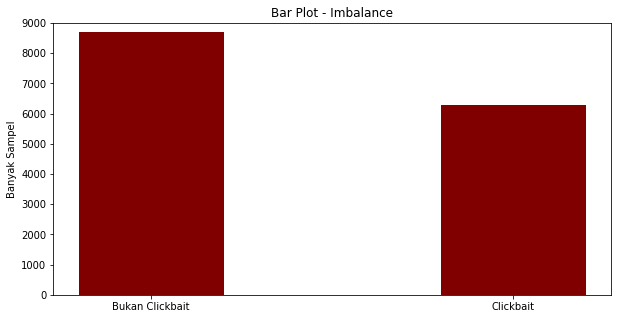

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(['Bukan Clickbait', 'Clickbait'], df['label_score'].value_counts(), color ='maroon',
        width = 0.4)
 
plt.ylabel("Banyak Sampel")
plt.title("Bar Plot - Imbalance")
plt.ylim(0,9000)
plt.savefig(r'Hasil\Imbalance.jpg')
plt.show()


In [7]:
df_clickbait = df[df['label_score']==1]
df_clickbait
df_nonclickbait = df[df['label_score']==0]
df_nonclickbait_downsampled = df_nonclickbait.sample(6290)
dataset = pd.concat([df_clickbait,df_nonclickbait_downsampled])

,title,label_score
2,Viral! Driver Ojol di Bekasi Antar Pesanan Mak...,1
11,"Ada Motor Nyangkut di Atas Bambu di Sleman, Ko...",1
13,Pesan Gamblang Poyuono Menolak Revisi UU KPK,1
37,Detik-detik Lima Kendaraan Alami Kecelakaan Be...,1
38,Kocak! Maling di Rumah Mewah Jakut Terekam CCT...,1
...,...,...
12646,Jadwal dan Prediksi Susunan Pemain Timnas Indo...,0
11311,"Revisi Tatib Baru DPRD DKI, Bakal Mengikat Pej...",0
9835,Amnesty International Tuding Polisi Hong Kong ...,0
9492,4 Mobil Konsep Daihatsu Mejeng di Tokyo Motor ...,0


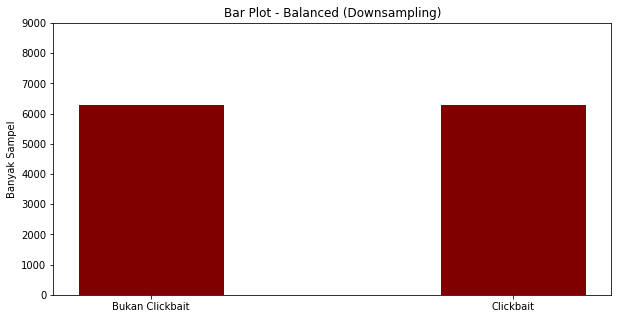

In [8]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(['Bukan Clickbait', 'Clickbait'], dataset['label_score'].value_counts(), color ='maroon',
        width = 0.4)
 
plt.ylabel("Banyak Sampel")
plt.title("Bar Plot - Balanced (Downsampling)")
plt.ylim(0,9000)
plt.savefig(r'Hasil\Balanced.jpg')
plt.show()

In [9]:
dataset['label_score'].value_counts()

1    6290
0    6290
Name: label_score, dtype: int64

## Data Cleaning

In [10]:
# Pembersihan
import numpy as np
import re

stopwords = pd.read_csv("Dataset\stopwords\stopwords_id.csv")

def clean_text(title):
    
    # Convert to lower case
    title = title.lower()
    # Remove additional white spaces
    title = re.sub('[\s]+', ' ', title)
    #trim
    title = title.strip('\'"')
    
    # Clean per Words
    words = title.split()
    tokens = []
    for ww in words:
        # split repeated word
        for w in re.split(r'[-/\s]\s*', ww):
            # replace two or more with two occurrences
            pattern = re.compile(r"(.)\1{1,}", re.DOTALL)
            w = pattern.sub(r"\1\1", w)
            # strip punctuation
            w = w.strip('\'"?,.')
            # check if the word cosists of two or more alphabets
            val = re.search(r"^[a-zA-Z][a-zA-Z][a-zA-Z]*$", w)
            # add tokens
            if(w in stopwords or val is None):
                continue
            else:
                tokens.append(w.lower())
    
    title = " ".join(tokens)
    return title


dataset["title"] = dataset['title'].map(lambda x: clean_text(x))
dataset = dataset[dataset['title'].apply(lambda x: len(x.split()) >=1)]
dataset.shape
labels = np.array(dataset['label_score'])

In [11]:
max = 0
longest_title = ''
for i in dataset["title"]:
    temp = len(i.split())
    if temp > max:
        max = temp
        longest_title = i
    else:
        continue
print("Judul terpanjang {} kata, yaitu: \"{}\"".format(max, longest_title))

Judul terpanjang 18 kata, yaitu: "kecantikan jang dong yoon jadi bahasan di lokasi the tale of nokdu kim so hyun ngaku kalah cantik"


## Data Splitting

In [13]:
# Pemisahan Data Training dan Testing
from sklearn.model_selection import train_test_split

train_data_text, test_data_text, train_labels, test_labels = train_test_split(
    dataset['title'], labels, test_size=0.2, random_state=42, stratify=labels)

In [14]:
uniqueTrain, countsTrain = np.unique(train_labels, return_counts=True)
uniqueTest, countsTest = np.unique(test_labels, return_counts=True)

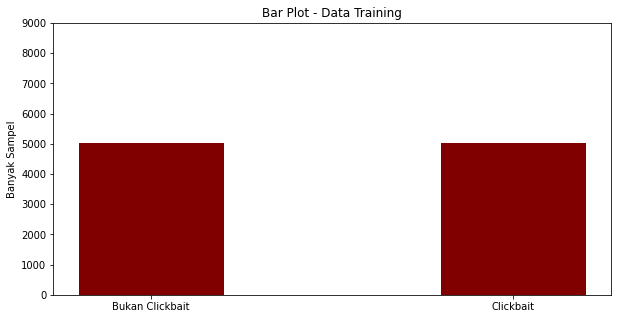

In [15]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(['Bukan Clickbait', 'Clickbait'], countsTrain, color ='maroon',
        width = 0.4)
 
plt.ylabel("Banyak Sampel")
plt.title("Bar Plot - Data Training")
plt.ylim(0,9000)
plt.savefig(r'Hasil\TrainBalanced.jpg')
plt.show()

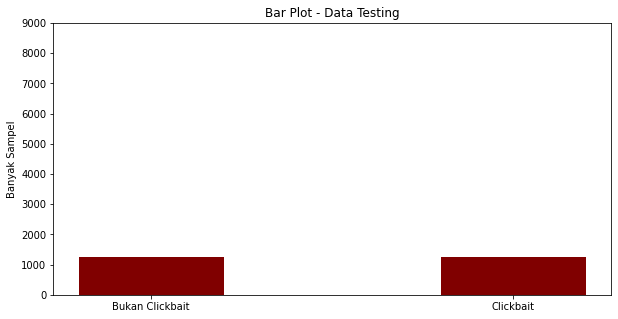

In [17]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(['Bukan Clickbait', 'Clickbait'], countsTest, color ='maroon',
        width = 0.4)
 
plt.ylabel("Banyak Sampel")
plt.title("Bar Plot - Data Testing")
plt.ylim(0,9000)
plt.savefig(r'Hasil\TestBalanced.jpg')
plt.show()

# Modelling

## BERT

### Import Pretrained BERT

In [18]:
# Pemilihan pretrained model
from tensorflow import keras
import tensorflow_hub as hub
from transformers import TFBertModel, BertConfig, AutoTokenizer, AutoModel

config = BertConfig.from_pretrained("indobenchmark/indobert-base-p2")
config.hidden_dropout_prob = 0.2
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
BERTencoder = TFBertModel.from_pretrained("indobenchmark/indobert-base-p2", trainable = False,
                                          config = config)


Some layers from the model checkpoint at indobenchmark/indobert-base-p2 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


### Tokenizing

In [19]:
max_length = 30
def tokenisasi(teks):
    encode_dict = tokenizer(teks,
                            add_special_tokens = True,
                            max_length = max_length,
                            padding = 'max_length',
                            truncation = True,
                            return_attention_mask = True,
                            return_tensors = 'tf')
    tokenID = encode_dict['input_ids']
    attention_mask = encode_dict['attention_mask']
    return tokenID, attention_mask

def create_input(data):
    tokenID, input_mask = [], []
    for teks in data:
        token, mask = tokenisasi(teks)
        tokenID.append(token)
        input_mask.append(mask)
    return [np.asarray(tokenID, dtype=np.int32).reshape(-1,max_length),
            np.asarray(input_mask, dtype=np.int32).reshape(-1,max_length)]

In [20]:
x_train_bert = create_input(train_data_text)
x_test_bert = create_input(test_data_text)

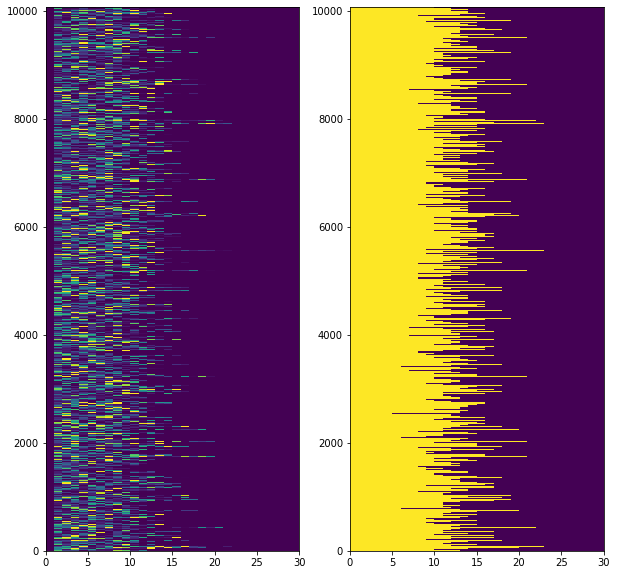

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.pcolormesh(x_train_bert[0])
plt.subplot(1,2,2)
plt.pcolormesh(x_train_bert[1])

### Model Building: BERT-CNN

In [30]:
# Model Building
from tensorflow import keras
from kerastuner.tuners import BayesianOptimization
from livelossplot.tf_keras import PlotLossesCallback
from livelossplot.outputs import MatplotlibPlot
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from keras.models import load_model
from os import path
import datetime
from tensorflow_addons.optimizers import AdamW

def model_builderBERTCNN(hp):
    max_length = 30
    
    # input_ids = Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
    # input_mask = Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')
    
    input_token = Input(shape=(max_length,), dtype=np.int32, name='input_token')
    input_mask = Input(shape=(max_length,), dtype=np.int32, name='input_mask')
    
    bert = BERTencoder([input_token, input_mask])[0]
    
    cnn = keras.layers.Conv1D(filters = hp.Int('filters',
                                               min_value = 50,
                                               max_value = 200,
                                               step = 10),
                              kernel_size = hp.Int('kernel_size',
                                                    min_value = 1,
                                                    max_value = 3,
                                                    step = 1),
                              activation = 'relu',
                              kernel_regularizer = keras.regularizers.l2(hp.Choice('kernel_cnn', values = [0.01, 0.001])))(bert)
    
    out = keras.layers.GlobalMaxPooling1D()(cnn)
    out = tf.keras.layers.Dropout(0.3)(out)
    out = Dense(units = hp.Int('units',
                            min_value = 16, 
                            max_value = 256, 
                            step = 32), 
            activation = 'relu')(out)
    out = tf.keras.layers.Dropout(0.3)(out)
    out = Dense(1, activation='sigmoid',
                kernel_regularizer = keras.regularizers.l2(hp.Choice('kernel_dense', values = [0.1, 0.01, 0.001])))(out)

    model = tf.keras.Model(inputs=[input_token, input_mask], outputs = out)
    
    model.compile(optimizer = AdamW(hp.Choice('weight_decay', 
                                            values = [1e-1, 1e-2, 1e-3, 1e-4]),
                                    hp.Choice('learning_rate', 
                                            values = [5e-4, 5e-5, 3e-5, 2e-5])),
                loss='binary_crossentropy',
                metrics=['accuracy',
                         keras.metrics.Precision(name='precision'),
                         keras.metrics.Recall(name='recall')])
    model.summary()
    return model

tunerBERTCNN = BayesianOptimization(model_builderBERTCNN,
                            objective = 'val_accuracy', 
                            max_trials = 8,
                            directory = 'Hasil',
                            project_name = 'Clickbait/BERTCNN')

# Search the optimal hyperparameters
earlystoppingBERTCNN = keras.callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 3,  
                                        restore_best_weights = True)
plotlossesBERTCNN = PlotLossesCallback(outputs=[MatplotlibPlot(figpath =r'Hasil\PlotBERTCNN.png')])


if path.exists(r'Hasil\BERTCNN.h5'):
    tunerBERTCNN.search(x_train_bert, 
                    train_labels, batch_size=256, epochs = 200, 
                    validation_data = (x_test_bert, test_labels), 
                    callbacks =[earlystoppingBERTCNN])

    best_hps_BERTCNN = tunerBERTCNN.get_best_hyperparameters()[0]
    modelBERTCNN = tunerBERTCNN.hypermodel.build(best_hps_BERTCNN)
    modelBERTCNN.load_weights(r'Hasil\BERTCNN.h5')
    
else:
    start_tuning = datetime.datetime.now()
    tunerBERTCNN.search(x_train_bert, 
                    train_labels, batch_size=256, epochs = 200, 
                    validation_data = (x_test_bert, test_labels), 
                    callbacks =[earlystoppingBERTCNN])
    stop_tuning = datetime.datetime.now()
    
    # Get the optimal hyperparameters
    
    best_hps_BERTCNN = tunerBERTCNN.get_best_hyperparameters()[0]
    
    print(f"""
    The hyperparameter search is complete. 
    The optimal number of units is {best_hps_BERTCNN.get('units')} 
    The optimal learning rate for the optimizer is {best_hps_BERTCNN.get('learning_rate')}.
    """)

    modelBERTCNN = tunerBERTCNN.hypermodel.build(best_hps_BERTCNN)
    
    start_training = datetime.datetime.now()
    modelBERTCNN.fit(x_train_bert, 
                  train_labels, batch_size=256, epochs = 200, 
                  validation_data = (x_test_bert, test_labels), 
                  callbacks=[earlystoppingBERTCNN, plotlossesBERTCNN],
                  verbose=1)
    stop_training = datetime.datetime.now()
    modelBERTCNN.save(r'Hasil\BERTCNN.h5')
    
    tuning_time = (stop_tuning-start_tuning).total_seconds() 
    training_time = (stop_training-start_training).total_seconds() 
    print('Tuning Time: ', tuning_time)
    print('Training Time: ', training_time)

    outfile = r'Hasil\BERTCNNlog.txt'

    with open(outfile, 'w') as f:
        f.write('fine-tuning time = {} seconds'.format(tuning_time))
        f.write("\n")
        f.write('training time = {} seconds'.format(training_time))

INFO:tensorflow:Reloading Oracle from existing project Hasil\Clickbait/BERTCNN\oracle.json
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 30)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 30)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  124441344   ['input_token[0][0]',            
                                thPoolingAndCrossAt               'input_mask[0][0]']             
                                tentions(last_hidde                                               
 

In [ ]:
print(f"""
The hyperparameter search is complete. 
The optimal number of filters is {best_hps_BERTCNN.get('filters')}.
The optimal number of kernel_size is {best_hps_BERTCNN.get('kernel_size')}.
The optimal number of units is {best_hps_BERTCNN.get('units')}.
The optimal learning rate for the optimizer is {best_hps_BERTCNN.get('learning_rate')}.
The optimal kernel_cnn is {best_hps_BERTCNN.get('kernel_cnn')}.
The optimal kernel_dense is {best_hps_BERTCNN.get('kernel_dense')}.
The optimal weight_decay is {best_hps_BERTCNN.get('weight_decay')}.
""")


The hyperparameter search is complete. 
The optimal number of filters is 200.
The optimal number of kernel_size is 1.
The optimal number of units is 16.
The optimal learning rate for the optimizer is 0.0005.
The optimal kernel_cnn is 0.001.
The optimal kernel_dense is 0.1.
The optimal weight_decay is 0.0001.



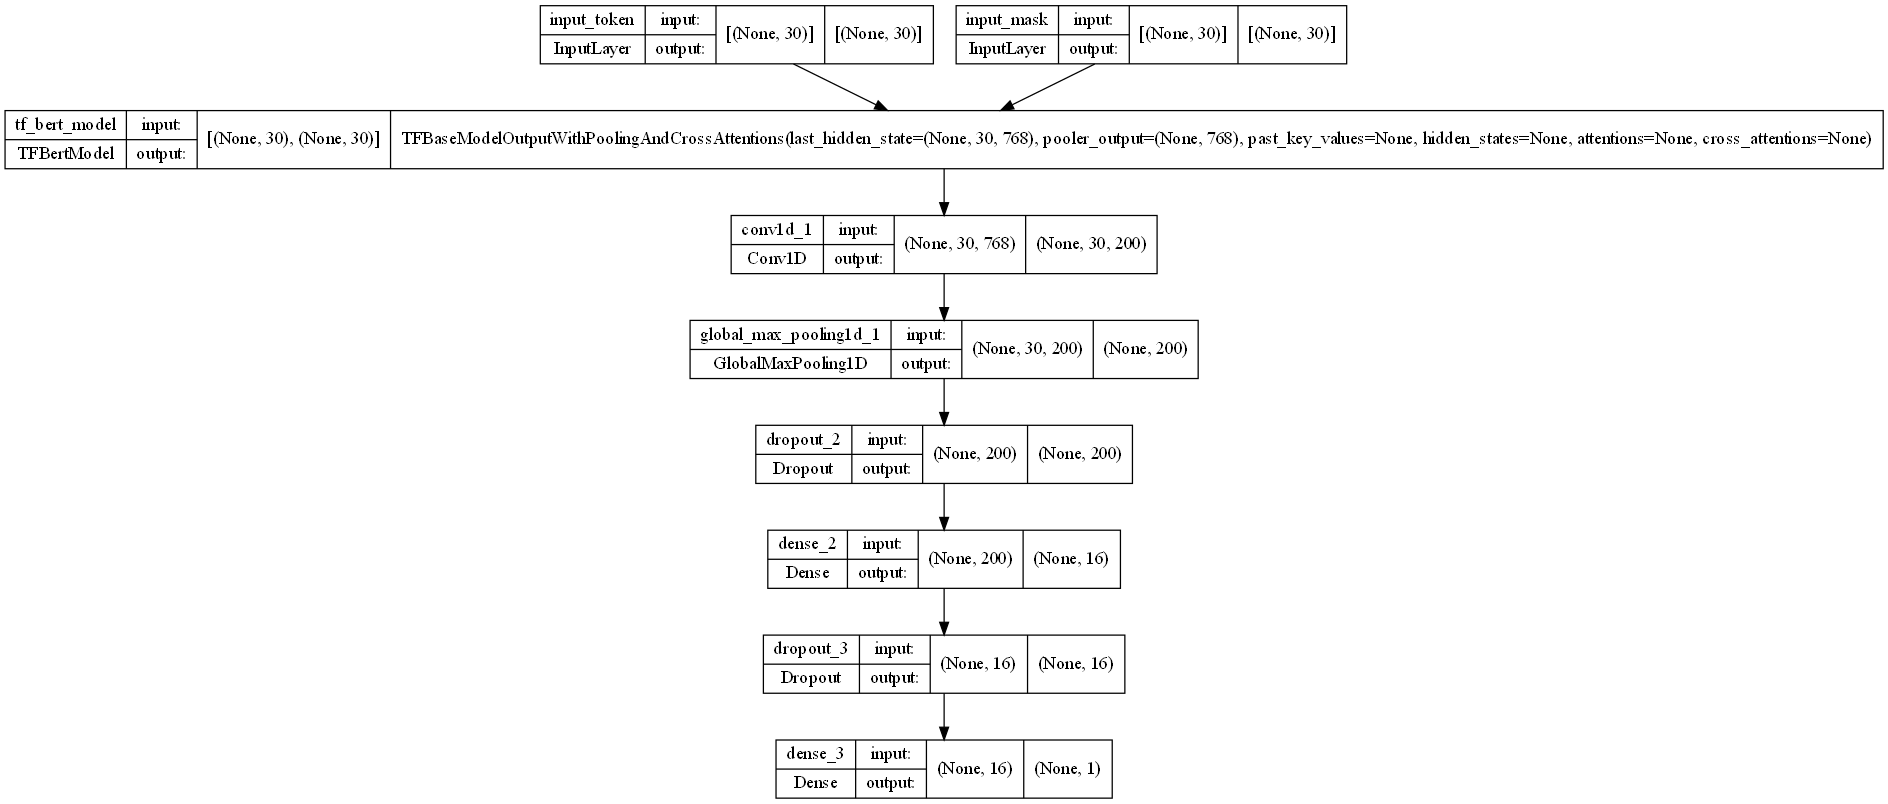

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(modelBERTCNN, show_shapes=True, dpi=91)

#### Evaluasi Model

In [ ]:
#  Evaluasi Model
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report

y_pred = [int(i > .5) for i in modelBERTCNN.predict(x_test_bert, verbose = 1)]

print('Accuracy:', accuracy_score(test_labels, y_pred))
print('F1 score:', f1_score(test_labels, y_pred, average='macro'))
print('Recall:', recall_score(test_labels, y_pred, average='macro'))
print('Precision:', precision_score(test_labels, y_pred, average='macro'))
print('\n clasification report:\n', classification_report(test_labels,y_pred))

79/79 [==============================] - 11s 132ms/step
Accuracy: 0.7881558028616852
F1 score: 0.7875441359524374
Recall: 0.7881558028616853
Precision: 0.7915129009760673

 clasification report:
               precision    recall  f1-score   support

           0       0.76      0.84      0.80      1258
           1       0.82      0.73      0.78      1258

    accuracy                           0.79      2516
   macro avg       0.79      0.79      0.79      2516
weighted avg       0.79      0.79      0.79      2516



### Model Building: BERT-LSTM

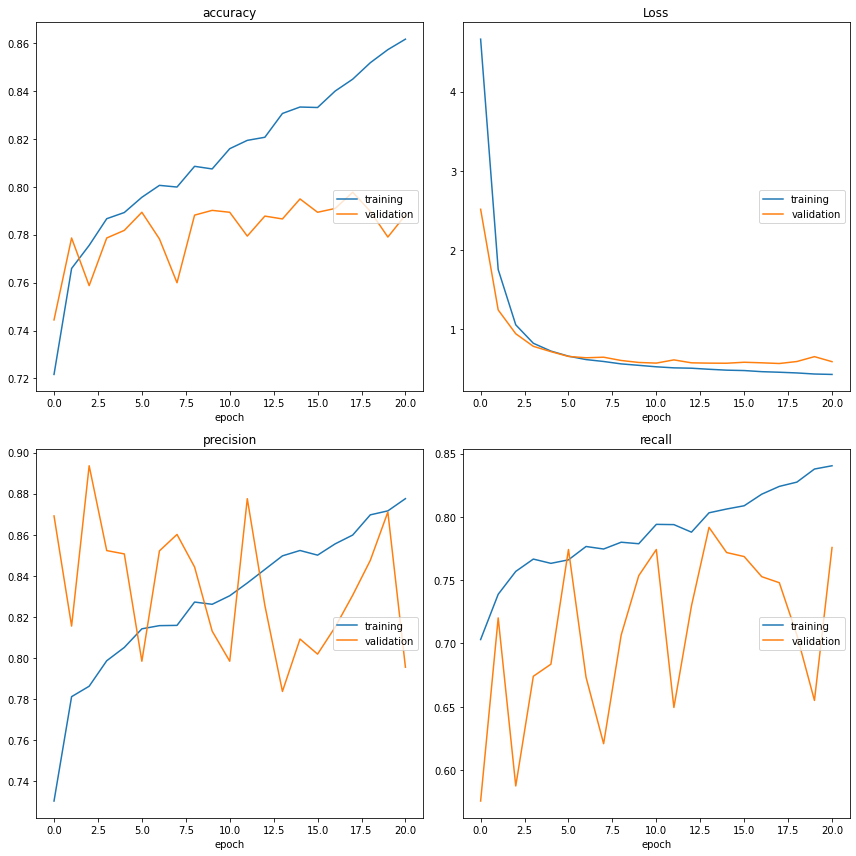

40/40 [==============================] - 59s 1s/step - loss: 0.4331 - accuracy: 0.8616 - precision: 0.8776 - recall: 0.8404 - val_loss: 0.5942 - val_accuracy: 0.7882 - val_precision: 0.7954 - val_recall: 0.7758
Tuning Time:  4323.778
Training Time:  1242.730664


In [23]:
# Model Building
from tensorflow import keras
from kerastuner.tuners import BayesianOptimization
from livelossplot.tf_keras import PlotLossesCallback
from livelossplot.outputs import MatplotlibPlot
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from keras.models import load_model
from os import path
import datetime
from tensorflow_addons.optimizers import AdamW

def model_builderBERTLSTM(hp):
    max_length = 30
    
    # input_ids = Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
    # input_mask = Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')
    
    input_token = Input(shape=(max_length,), dtype=np.int32, name='input_token')
    input_mask = Input(shape=(max_length,), dtype=np.int32, name='input_mask')
    
    bert = BERTencoder([input_token, input_mask])[0]
    
    lstm = keras.layers.LSTM(units = hp.Int('unitsLSTM',
                                               min_value = 300,
                                               max_value = 600,
                                               step = 50),
                             kernel_regularizer = keras.regularizers.l2(hp.Choice('kernel_regularizer',
                                                                                  values = [0.001, 0.0001, 0.00001])),
                             recurrent_regularizer = keras.regularizers.l2(hp.Choice('rec_regularizer',
                                                                                    values = [0.01, 0.001])),
                             return_sequences = True)(bert)
    
    out = keras.layers.GlobalMaxPooling1D()(lstm)
    out = tf.keras.layers.Dropout(0.3)(out)
    out = Dense(units = hp.Int('units',
                            min_value = 16, 
                            max_value = 256, 
                            step = 32), 
            activation = 'relu')(out)
    out = tf.keras.layers.Dropout(0.3)(out)
    out = Dense(1, activation='sigmoid',
                kernel_regularizer = keras.regularizers.l2(hp.Choice('kernel_dense', values = [0.1, 0.01, 0.001])))(out)

    model = tf.keras.Model(inputs=[input_token, input_mask], outputs = out)
    
    model.compile(optimizer = AdamW(hp.Choice('weight_decay', 
                                            values = [1e-1, 1e-2, 1e-3, 1e-4]),
                                    hp.Choice('learning_rate', 
                                            values = [5e-4, 5e-5, 3e-5, 2e-5])),
                loss='binary_crossentropy',
                metrics=['accuracy',
                         keras.metrics.Precision(name='precision'),
                         keras.metrics.Recall(name='recall')])
    model.summary()
    return model

tunerBERTLSTM = BayesianOptimization(model_builderBERTLSTM,
                            objective = 'val_accuracy', 
                            max_trials = 8,
                            directory = 'Hasil',
                            project_name = 'Clickbait/BERTLSTM')

# Search the optimal hyperparameters
earlystoppingBERTLSTM = keras.callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 3,  
                                        restore_best_weights = True)
plotlossesBERTLSTM = PlotLossesCallback(outputs=[MatplotlibPlot(figpath =r'Hasil\PlotBERTLSTM.png')])


if path.exists(r'Hasil\BERTLSTM.h5'):
    tunerBERTLSTM.search(x_train_bert, 
                    train_labels, batch_size=256, epochs = 200, 
                    validation_data = (x_test_bert, test_labels), 
                    callbacks =[earlystoppingBERTLSTM])

    best_hps_BERTLSTM = tunerBERTLSTM.get_best_hyperparameters()[0]
    modelBERTLSTM = tunerBERTLSTM.hypermodel.build(best_hps_BERTLSTM)
    modelBERTLSTM.load_weights(r'Hasil\BERTLSTM.h5')
    
else:
    start_tuning = datetime.datetime.now()
    tunerBERTLSTM.search(x_train_bert, 
                    train_labels, batch_size=256, epochs = 200, 
                    validation_data = (x_test_bert, test_labels), 
                    callbacks =[earlystoppingBERTLSTM])
    stop_tuning = datetime.datetime.now()
    
    # Get the optimal hyperparameters
    
    best_hps_BERTLSTM = tunerBERTLSTM.get_best_hyperparameters()[0]
    
    print(f"""
    The hyperparameter search is complete. 
    The optimal number of units is {best_hps_BERTLSTM.get('units')} 
    The optimal learning rate for the optimizer is {best_hps_BERTLSTM.get('learning_rate')}.
    """)

    modelBERTLSTM = tunerBERTLSTM.hypermodel.build(best_hps_BERTLSTM)
    
    start_training = datetime.datetime.now()
    modelBERTLSTM.fit(x_train_bert, 
                  train_labels, batch_size=256, epochs = 200, 
                  validation_data = (x_test_bert, test_labels), 
                  callbacks=[earlystoppingBERTLSTM, plotlossesBERTLSTM],
                  verbose=1)
    stop_training = datetime.datetime.now()
    modelBERTLSTM.save(r'Hasil\BERTLSTM.h5')
    
    tuning_time = (stop_tuning-start_tuning).total_seconds() 
    training_time = (stop_training-start_training).total_seconds() 
    print('Tuning Time: ', tuning_time)
    print('Training Time: ', training_time)

    outfile = r'Hasil\BERTLSTMlog.txt'

    with open(outfile, 'w') as f:
        f.write('fine-tuning time = {} seconds'.format(tuning_time))
        f.write("\n")
        f.write('training time = {} seconds'.format(training_time))

In [24]:
print(f"""
The hyperparameter search is complete. 
The optimal number of units is {best_hps_BERTLSTM.get('units')}.
The optimal learning rate for the optimizer is {best_hps_BERTLSTM.get('learning_rate')}.
The optimal unitsLSTM is {best_hps_BERTLSTM.get('unitsLSTM')}.
The optimal kernel_regularizer is {best_hps_BERTLSTM.get('kernel_regularizer')}.
The optimal rec_regularizer is {best_hps_BERTLSTM.get('rec_regularizer')}.
The optimal kernel_dense is {best_hps_BERTLSTM.get('kernel_dense')}.
The optimal weight_decay is {best_hps_BERTLSTM.get('weight_decay')}.
""")


The hyperparameter search is complete. 
The optimal number of units is 240.
The optimal learning rate for the optimizer is 0.0005.
The optimal unitsLSTM is 600.
The optimal kernel_regularizer is 0.001.
The optimal rec_regularizer is 0.01.
The optimal kernel_dense is 0.001.
The optimal weight_decay is 0.0001.



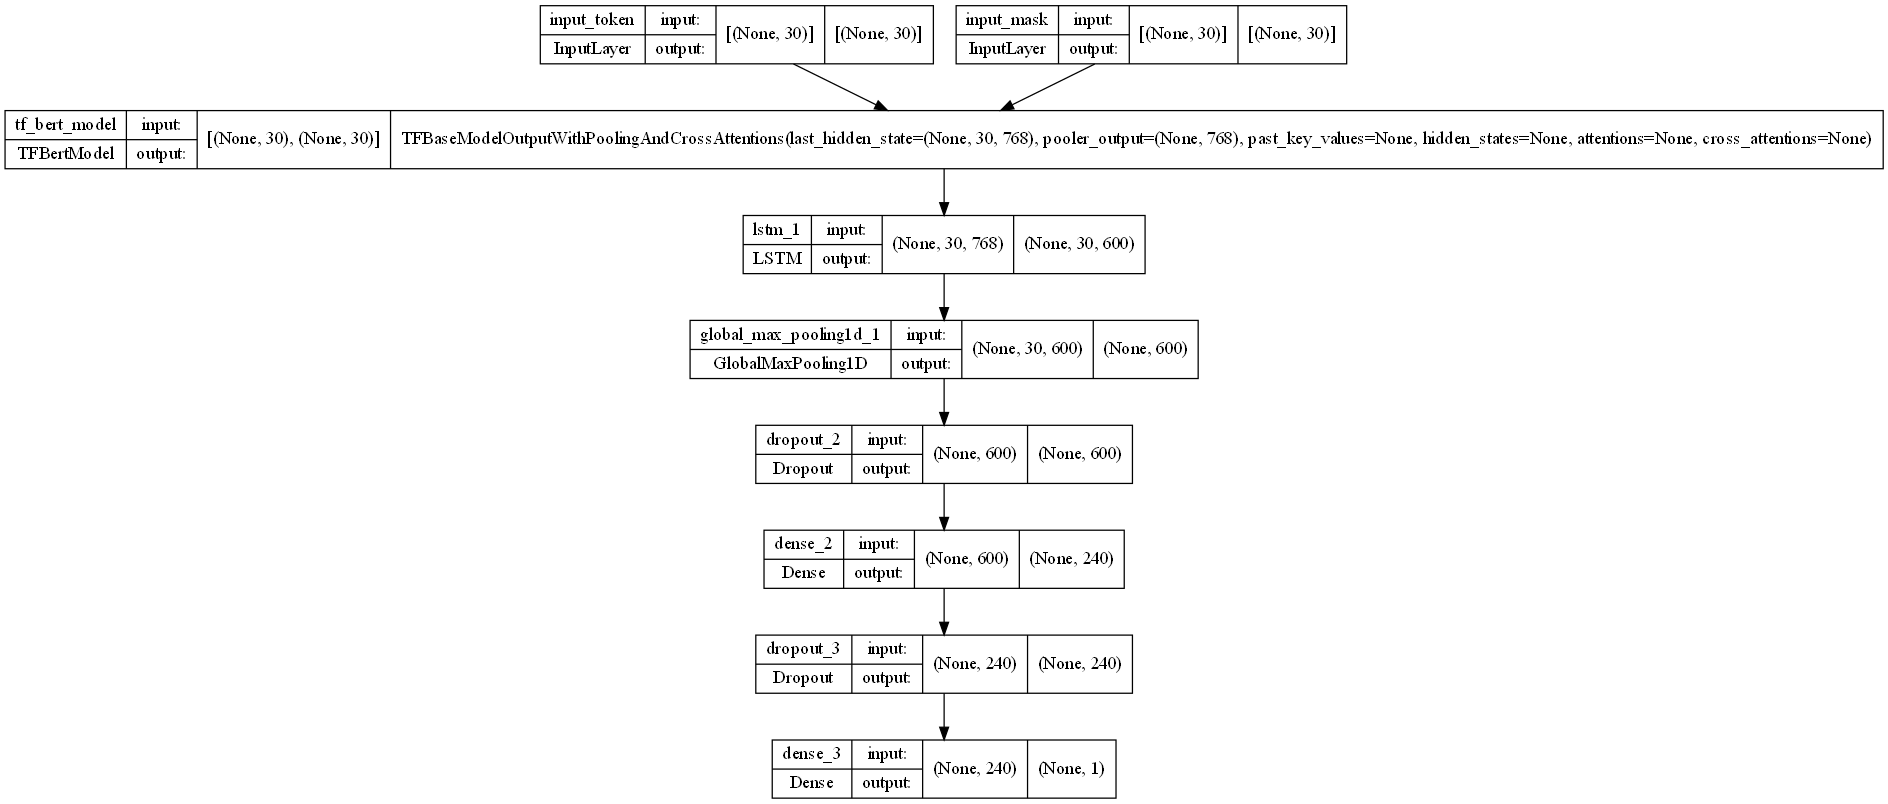

In [25]:
import tensorflow as tf
tf.keras.utils.plot_model(modelBERTLSTM, show_shapes=True, dpi=91)

#### Evaluasi Model

In [27]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report

y_pred = [int(i > .5) for i in modelBERTLSTM.predict(x_test_bert, verbose = 1)]

print('Accuracy:', accuracy_score(test_labels, y_pred))
print('F1 score:', f1_score(test_labels, y_pred, average='macro'))
print('Recall:', recall_score(test_labels, y_pred, average='macro'))
print('Precision:', precision_score(test_labels, y_pred, average='macro'))
print('\n clasification report:\n', classification_report(test_labels,y_pred))

79/79 [==============================] - 11s 135ms/step
Accuracy: 0.7976947535771065
F1 score: 0.7971941670067499
Recall: 0.7976947535771065
Precision: 0.8006632676830432

 clasification report:
               precision    recall  f1-score   support

           0       0.77      0.85      0.81      1258
           1       0.83      0.75      0.79      1258

    accuracy                           0.80      2516
   macro avg       0.80      0.80      0.80      2516
weighted avg       0.80      0.80      0.80      2516



## Word2Vec

### Import Pretrained Word2Vec

In [23]:
import gensim

path = r'word2vec\idwiki_word2vec_200_new_lower.model'
id_w2v = gensim.models.word2vec.Word2Vec.load(path)


### Tokenizing

In [24]:
from tensorflow.keras.layers import Embedding

def gensim_to_keras_embedding(model, train_embeddings=False):
    """Get a Keras 'Embedding' layer with weights set from Word2Vec model's learned word embeddings.

    Parameters
    ----------
    train_embeddings : bool
        If False, the returned weights are frozen and stopped from being updated.
        If True, the weights can / will be further updated in Keras.

    Returns
    -------
    `keras.layers.Embedding`
        Embedding layer, to be used as input to deeper network layers.

    """
    keyed_vectors = model.wv  # structure holding the result of training
    weights = keyed_vectors.vectors  # vectors themselves, a 2D numpy array    
    index_to_key = keyed_vectors.index_to_key  # which row in `weights` corresponds to which word?

    layer = Embedding(
        input_dim=weights.shape[0],
        output_dim=weights.shape[1],
        weights=[weights],
        trainable=train_embeddings,
    )
    return layer

w2v = gensim_to_keras_embedding(id_w2v)

In [25]:
from keras.preprocessing.sequence import pad_sequences
def word2token(word):
    try:
        return id_w2v.wv.key_to_index[word]
    # If word is not in index return 0. I realize this means that this
    # is the same as the word of index 0 (i.e. most frequent word), but 0s
    # will be padded later anyway by the embedding layer (which also
    # seems dirty but I couldn't find a better solution right now)
    except KeyError:
        return 0
def token2word(token):
    return id_w2v.wv.index2word[token]

def tokenizer_word2vec(data, max_length):
    tokens = []
    for teks in data:
        tokens.append(np.array([word2token(w) for w in teks.split(' ') if w != '']))
    padded_tokens = pad_sequences(tokens, maxlen=max_length, padding='pre', value=0)
    return padded_tokens



In [26]:
max_length = 30
x_train_w2v = tokenizer_word2vec(train_data_text, max_length)
x_test_w2v = tokenizer_word2vec(test_data_text, max_length)

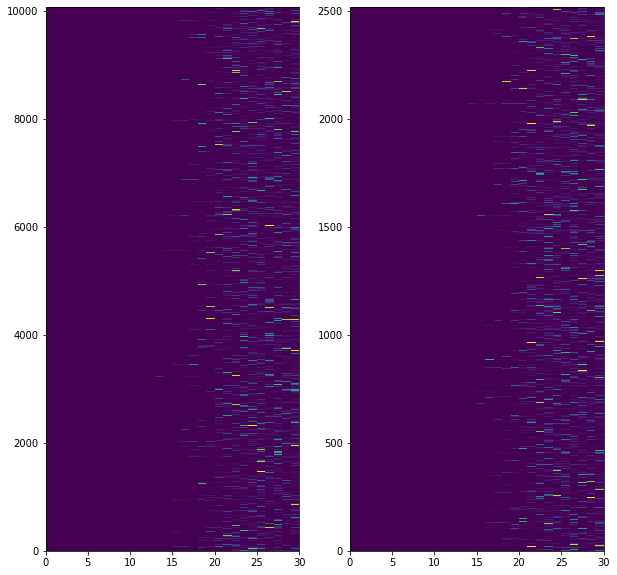

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.pcolormesh(x_train_w2v)
plt.subplot(1,2,2)
plt.pcolormesh(x_test_w2v)

### Model Building: Word2Vec-CNN

In [32]:
# Model Building
from tensorflow import keras
from kerastuner.tuners import BayesianOptimization
from livelossplot.tf_keras import PlotLossesCallback
from livelossplot.outputs import MatplotlibPlot
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from keras.models import load_model
from os import path
import datetime
from tensorflow_addons.optimizers import AdamW

def model_builderW2VCNN(hp):
    max_length = 30
    
    # input_ids = Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
    # input_mask = Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')
    
    input_token = Input(shape=(max_length,), dtype=np.int32, name='input_token')
    
    embeddingw2v = w2v(input_token)
    
    cnn = keras.layers.Conv1D(filters = hp.Int('filters',
                                               min_value = 50,
                                               max_value = 200,
                                               step = 10),
                              kernel_size = hp.Int('kernel_size',
                                                    min_value = 1,
                                                    max_value = 3,
                                                    step = 1),
                              activation = 'relu',
                              kernel_regularizer = keras.regularizers.l2(hp.Choice('kernel_cnn', values = [0.01, 0.001])))(embeddingw2v)
    
    out = keras.layers.GlobalMaxPooling1D()(cnn)
    out = tf.keras.layers.Dropout(0.3)(out)
    out = Dense(units = hp.Int('units',
                            min_value = 16, 
                            max_value = 256, 
                            step = 32), 
            activation = 'relu')(out)
    out = tf.keras.layers.Dropout(0.3)(out)
    out = Dense(1, activation='sigmoid',
                kernel_regularizer = keras.regularizers.l2(hp.Choice('kernel_dense', values = [0.1, 0.01, 0.001])))(out)

    model = tf.keras.Model(inputs=[input_token], outputs = out)
    
    model.compile(optimizer = AdamW(hp.Choice('weight_decay', 
                                            values = [1e-1, 1e-2, 1e-3, 1e-4]),
                                    hp.Choice('learning_rate', 
                                            values = [5e-4, 5e-5, 3e-5, 2e-5])),
                loss='binary_crossentropy',
                metrics=['accuracy',
                         keras.metrics.Precision(name='precision'),
                         keras.metrics.Recall(name='recall')])
    model.summary()
    return model

tunerW2VCNN = BayesianOptimization(model_builderW2VCNN,
                            objective = 'val_accuracy', 
                            max_trials = 8,
                            directory = 'Hasil',
                            project_name = 'Clickbait/W2VCNN')

# Search the optimal hyperparameters
earlystoppingW2VCNN = keras.callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 3,  
                                        restore_best_weights = True)
plotlossesW2VCNN = PlotLossesCallback(outputs=[MatplotlibPlot(figpath =r'Hasil\PlotW2VCNN.png')])


if path.exists(r'Hasil\W2VCNN.h5'):
    tunerW2VCNN.search(x_train_w2v, 
                    train_labels, batch_size=256, epochs = 200, 
                    validation_data = (x_test_w2v, test_labels), 
                    callbacks =[earlystoppingW2VCNN])

    best_hps_W2VCNN = tunerW2VCNN.get_best_hyperparameters()[0]
    modelW2VCNN = tunerW2VCNN.hypermodel.build(best_hps_W2VCNN)
    modelW2VCNN.load_weights(r'Hasil\W2VCNN.h5')
    
else:
    start_tuning = datetime.datetime.now()
    tunerW2VCNN.search(x_train_w2v, 
                    train_labels, batch_size=256, epochs = 200, 
                    validation_data = (x_test_w2v, test_labels), 
                    callbacks =[earlystoppingW2VCNN])
    stop_tuning = datetime.datetime.now()
    
    # Get the optimal hyperparameters
    
    best_hps_W2VCNN = tunerW2VCNN.get_best_hyperparameters()[0]
    
    print(f"""
    The hyperparameter search is complete. 
    The optimal number of units is {best_hps_W2VCNN.get('units')} 
    The optimal learning rate for the optimizer is {best_hps_W2VCNN.get('learning_rate')}.
    """)

    modelW2VCNN = tunerW2VCNN.hypermodel.build(best_hps_W2VCNN)
    
    start_training = datetime.datetime.now()
    modelW2VCNN.fit(x_train_w2v, 
                  train_labels, batch_size=256, epochs = 200, 
                  validation_data = (x_test_w2v, test_labels), 
                  callbacks=[earlystoppingW2VCNN, plotlossesW2VCNN],
                  verbose=1)
    stop_training = datetime.datetime.now()
    modelW2VCNN.save(r'Hasil\W2VCNN.h5')
    
    tuning_time = (stop_tuning-start_tuning).total_seconds() 
    training_time = (stop_training-start_training).total_seconds() 
    print('Tuning Time: ', tuning_time)
    print('Training Time: ', training_time)

    outfile = r'Hasil\W2VCNNlog.txt'

    with open(outfile, 'w') as f:
        f.write('fine-tuning time = {} seconds'.format(tuning_time))
        f.write("\n")
        f.write('training time = {} seconds'.format(training_time))

INFO:tensorflow:Reloading Oracle from existing project Hasil\Clickbait/W2VCNN\oracle.json
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_token (InputLayer)    [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 200)           68308200  
                                                                 
 conv1d_2 (Conv1D)           (None, 30, 50)            10050     
                                                                 
 global_max_pooling1d_4 (Glo  (None, 50)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_45 (Dropout)        (None, 50)                0         
                                                                 
 dense_8 (Dense)             (None,

In [33]:
print(f"""
The hyperparameter search is complete. 
The optimal number of filters is {best_hps_W2VCNN.get('filters')}.
The optimal number of kernel_size is {best_hps_W2VCNN.get('kernel_size')}.
The optimal number of units is {best_hps_W2VCNN.get('units')}.
The optimal learning rate for the optimizer is {best_hps_W2VCNN.get('learning_rate')}.
The optimal kernel_cnn is {best_hps_W2VCNN.get('kernel_cnn')}.
The optimal kernel_dense is {best_hps_W2VCNN.get('kernel_dense')}.
The optimal weight_decay is {best_hps_W2VCNN.get('weight_decay')}.
""")


The hyperparameter search is complete. 
The optimal number of filters is 70.
The optimal number of kernel_size is 2.
The optimal number of units is 112.
The optimal learning rate for the optimizer is 0.0005.
The optimal kernel_cnn is 0.01.
The optimal kernel_dense is 0.001.
The optimal weight_decay is 0.001.



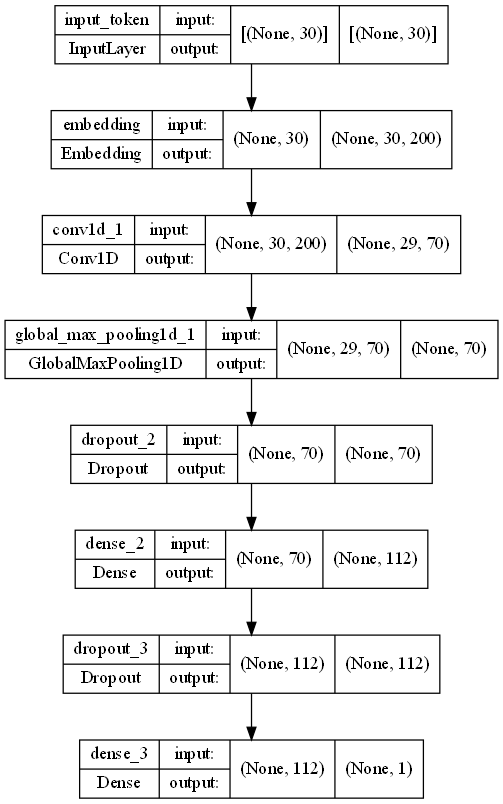

In [36]:
import tensorflow as tf
tf.keras.utils.plot_model(modelW2VCNN, show_shapes=True, dpi=91)

#### Evaluasi Model

In [35]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report

y_pred = [int(i > .5) for i in modelW2VCNN.predict(x_test_w2v, verbose = 1)]

print('Accuracy:', accuracy_score(test_labels, y_pred))
print('F1 score:', f1_score(test_labels, y_pred, average='macro'))
print('Recall:', recall_score(test_labels, y_pred, average='macro'))
print('Precision:', precision_score(test_labels, y_pred, average='macro'))
print('\n clasification report:\n', classification_report(test_labels,y_pred))

79/79 [==============================] - 1s 5ms/step
Accuracy: 0.7655007949125596
F1 score: 0.7651297668955181
Recall: 0.7655007949125596
Precision: 0.767189125530026

 clasification report:
               precision    recall  f1-score   support

           0       0.75      0.81      0.77      1258
           1       0.79      0.73      0.76      1258

    accuracy                           0.77      2516
   macro avg       0.77      0.77      0.77      2516
weighted avg       0.77      0.77      0.77      2516



### Model Building: Word2Vec-LSTM

In [28]:
# Model Building
from tensorflow import keras
from kerastuner.tuners import BayesianOptimization
from livelossplot.tf_keras import PlotLossesCallback
from livelossplot.outputs import MatplotlibPlot
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from keras.models import load_model
from os import path
import datetime
from tensorflow_addons.optimizers import AdamW

def model_builderW2VLSTM(hp):
    max_length = 30
    
    # input_ids = Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
    # input_mask = Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')
    
    input_token = Input(shape=(max_length,), dtype=np.int32, name='input_token')
    
    embeddingw2v = w2v(input_token)
    
    lstm = keras.layers.LSTM(units = hp.Int('unitsLSTM',
                                               min_value = 300,
                                               max_value = 600,
                                               step = 50),
                             kernel_regularizer = keras.regularizers.l2(hp.Choice('kernel_regularizer',
                                                                                  values = [0.001, 0.0001, 0.00001])),
                             recurrent_regularizer = keras.regularizers.l2(hp.Choice('rec_regularizer',
                                                                                    values = [0.01, 0.001])),
                             return_sequences = True)(embeddingw2v)
    
    out = keras.layers.GlobalMaxPooling1D()(lstm)
    out = tf.keras.layers.Dropout(0.3)(out)
    out = Dense(units = hp.Int('units',
                            min_value = 16, 
                            max_value = 256, 
                            step = 32), 
            activation = 'relu')(out)
    out = tf.keras.layers.Dropout(0.3)(out)
    out = Dense(1, activation='sigmoid',
                kernel_regularizer = keras.regularizers.l2(hp.Choice('kernel_dense', values = [0.1, 0.01, 0.001])))(out)

    model = tf.keras.Model(inputs=[input_token], outputs = out)
    
    model.compile(optimizer = AdamW(hp.Choice('weight_decay', 
                                            values = [1e-1, 1e-2, 1e-3, 1e-4]),
                                    hp.Choice('learning_rate', 
                                            values = [5e-4, 5e-5, 3e-5, 2e-5])),
                loss='binary_crossentropy',
                metrics=['accuracy',
                         keras.metrics.Precision(name='precision'),
                         keras.metrics.Recall(name='recall')])
    model.summary()
    return model

tunerW2VLSTM = BayesianOptimization(model_builderW2VLSTM,
                            objective = 'val_accuracy', 
                            max_trials = 8,
                            directory = 'Hasil',
                            project_name = 'Clickbait/W2VLSTM')

# Search the optimal hyperparameters
earlystoppingW2VLSTM = keras.callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 3,  
                                        restore_best_weights = True)
plotlossesW2VLSTM = PlotLossesCallback(outputs=[MatplotlibPlot(figpath =r'Hasil\PlotW2VLSTM.png')])


if path.exists(r'Hasil\W2VLSTM.h5'):
    tunerW2VLSTM.search(x_train_w2v, 
                    train_labels, batch_size=256, epochs = 200, 
                    validation_data = (x_test_w2v, test_labels), 
                    callbacks =[earlystoppingW2VLSTM])

    best_hps_W2VLSTM = tunerW2VLSTM.get_best_hyperparameters()[0]
    modelW2VLSTM = tunerW2VLSTM.hypermodel.build(best_hps_W2VLSTM)
    modelW2VLSTM.load_weights(r'Hasil\W2VLSTM.h5')
    
else:
    start_tuning = datetime.datetime.now()
    tunerW2VLSTM.search(x_train_w2v, 
                    train_labels, batch_size=256, epochs = 200, 
                    validation_data = (x_test_w2v, test_labels), 
                    callbacks =[earlystoppingW2VLSTM])
    stop_tuning = datetime.datetime.now()
    
    # Get the optimal hyperparameters
    
    best_hps_W2VLSTM = tunerW2VLSTM.get_best_hyperparameters()[0]
    
    print(f"""
    The hyperparameter search is complete. 
    The optimal number of units is {best_hps_W2VLSTM.get('units')} 
    The optimal learning rate for the optimizer is {best_hps_W2VLSTM.get('learning_rate')}.
    """)

    modelW2VLSTM = tunerW2VLSTM.hypermodel.build(best_hps_W2VLSTM)
    
    start_training = datetime.datetime.now()
    modelW2VLSTM.fit(x_train_w2v, 
                  train_labels, batch_size=256, epochs = 200, 
                  validation_data = (x_test_w2v, test_labels), 
                  callbacks=[earlystoppingW2VLSTM, plotlossesW2VLSTM],
                  verbose=1)
    stop_training = datetime.datetime.now()
    modelW2VLSTM.save(r'Hasil\W2VLSTM.h5')
    
    tuning_time = (stop_tuning-start_tuning).total_seconds() 
    training_time = (stop_training-start_training).total_seconds() 
    print('Tuning Time: ', tuning_time)
    print('Training Time: ', training_time)

    outfile = r'Hasil\W2VLSTMlog.txt'

    with open(outfile, 'w') as f:
        f.write('fine-tuning time = {} seconds'.format(tuning_time))
        f.write("\n")
        f.write('training time = {} seconds'.format(training_time))

INFO:tensorflow:Reloading Oracle from existing project Hasil\Clickbait/W2VLSTM\oracle.json
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_token (InputLayer)    [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 200)           68308200  
                                                                 
 lstm (LSTM)                 (None, 30, 300)           601200    
                                                                 
 global_max_pooling1d (Globa  (None, 300)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_37 (Dropout)        (None, 300)               0         
                                                                 
 dense (Dense)               (None, 

In [29]:
print(f"""
The hyperparameter search is complete. 
The optimal number of units is {best_hps_W2VLSTM.get('units')}.
The optimal learning rate for the optimizer is {best_hps_W2VLSTM.get('learning_rate')}.
The optimal unitsLSTM is {best_hps_W2VLSTM.get('unitsLSTM')}.
The optimal kernel_regularizer is {best_hps_W2VLSTM.get('kernel_regularizer')}.
The optimal rec_regularizer is {best_hps_W2VLSTM.get('rec_regularizer')}.
The optimal kernel_dense is {best_hps_W2VLSTM.get('kernel_dense')}.
The optimal weight_decay is {best_hps_W2VLSTM.get('weight_decay')}.
""")


The hyperparameter search is complete. 
The optimal number of units is 16.
The optimal learning rate for the optimizer is 0.0005.
The optimal unitsLSTM is 350.
The optimal kernel_regularizer is 0.0001.
The optimal rec_regularizer is 0.01.
The optimal kernel_dense is 0.1.
The optimal weight_decay is 0.0001.



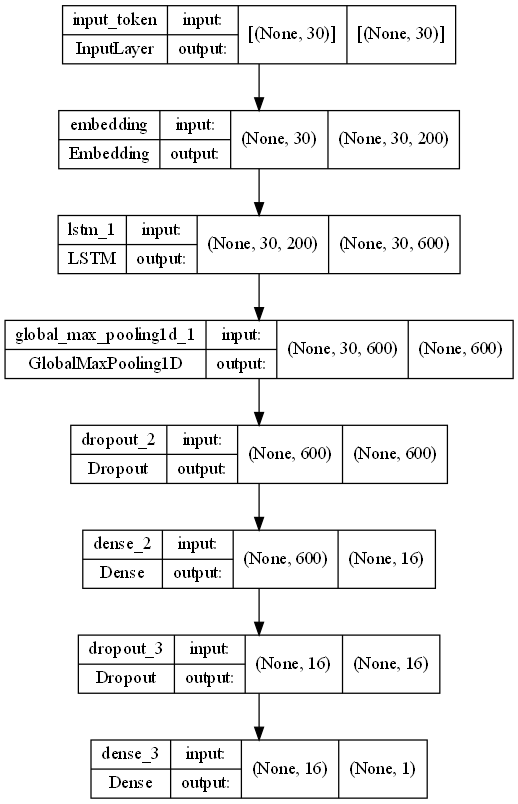

In [46]:
import tensorflow as tf
tf.keras.utils.plot_model(modelW2VLSTM, show_shapes=True, dpi=91)

#### Evaluasi Model

In [38]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report

y_pred = [int(i > .5) for i in modelW2VLSTM.predict(x_test_w2v, verbose = 1)]

print('Accuracy:', accuracy_score(test_labels, y_pred))
print('F1 score:', f1_score(test_labels, y_pred, average='macro'))
print('Recall:', recall_score(test_labels, y_pred, average='macro'))
print('Precision:', precision_score(test_labels, y_pred, average='macro'))
print('\n clasification report:\n', classification_report(test_labels,y_pred))

79/79 [==============================] - 2s 9ms/step
Accuracy: 0.7591414944356121
F1 score: 0.7591401246718124
Recall: 0.7591414944356121
Precision: 0.7591473894932665

 clasification report:
               precision    recall  f1-score   support

           0       0.76      0.76      0.76      1258
           1       0.76      0.76      0.76      1258

    accuracy                           0.76      2516
   macro avg       0.76      0.76      0.76      2516
weighted avg       0.76      0.76      0.76      2516

